In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator

import scipy.stats

from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
import json

## Declarations and definitions

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    """Calculate mean, and lower and upper bound of confidence interval"""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
def Dxy(event_observed, cve_lifetime, predicted_scores):
    """Calculate Dxy

    Rescale values from 0<=x<=1 range, where 0 is perfect anti-concordance,
    and 0.5 is the expected result from random predictions,
    to the -1<=x<=1 range
    """
    #return 2 * concordance_index_censored(event_observed, cve_lifetime, predicted_scores)[0] - 1
    return 2 * concordance_index(cve_lifetime, predicted_scores, event_observed) - 1

In [6]:
def bootstrap_dxy_inner(df):
    """Bootstrapped Dxy calculation, randomly sampled with replacement

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to sample to compute Dxy from concordance index.
        Assumes that first 3 columns in this dataframe are:

        1. boolean column denoting which events were observed (un-censored)
        2. column with event times, in this case CVE lifetime (time to fix)
        3. column with predicted score, assumed to be category number,
           ordered in such way that larger values predict shorter lifetime

        Other columns are not used.

    Returns
    -------
    float
        Coefficient of concordance correlation, a number between –1 and 1 that
        measures the strength and direction of the relationship between
        predicted score (risk factor) and event time (CVE survival lifetime).
    """
    e, y, x = df.columns
    sample = df.sample(n=df.shape[0], replace=True)

    # calculate Dxy from sample
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """Boostrap and calculate Dxy, resampling `n` times"""
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for _ in range(n))

    return result

In [7]:
def apply_stats_for_each_value(params, df, fmap, condition_names=None, df_mask=None):
    """Apply stats to each value in column"""

    all_count = df.shape[0]

    if df_mask is not None:
        df = df[df_mask]

    dff = pd.DataFrame({'E': df['E'], 'Y': df['Y'], 'agg': df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    print(f"all = {all_count}, selected = {selected_count}, uncensored = {dff['E'].sum()}",
               file=sys.stderr)

    # DEBUG
    #print(dff.head())

    stats = dff['Y'].aggregate(['count', 'median'])

    print(f"Computing {params['bootstrap_samples']} × bootstrap Dxy " +
          f"for {dff.shape[0]} elements...", file=sys.stderr)
    dxy_bootstrapped = bootstrap_dxy(dff[['E', 'Y', 'agg']], params['bootstrap_samples'])
    # DEBUG
    #print(dxy_bootstrapped)
    # confidence interval
    print(f"Computing confidence interval from {len(dxy_bootstrapped)} samples...", file=sys.stderr)
    dxy, ci_low, ci_high = mean_confidence_interval(dxy_bootstrapped, confidence=params['confidence'])

    ret = {
        'Cohort': all_count,
        'Number of patients': stats['count'],
        '% of cohort': 100.0*selected_count / all_count,
        'Survival days, median': stats['median'],
        'Survival years, median': stats['median'] / 365,
        'Dxy (full)': Dxy(dff['E'], dff['Y'], dff['agg']),
        'bootstrap': {
            'Dxy': dxy,
            'Confidence interval low': ci_low,
            'Confidence interval high': ci_high,
            'confidence threshold %': 100.0*params['confidence'],
            'bootstrap samples': params['bootstrap_samples'],
        },
    }

    print("Computing descriptive statistics like mean, median, etc....", file=sys.stderr)
    dff_groupby_y = dff.groupby(by=['agg'])['Y']
    groups = dff_groupby_y\
        .agg(['count', 'median', 'min',
              lambda x: np.percentile(x, q=25), lambda x: np.percentile(x, q=75),
              'max', 'mean', 'std', 'skew'])\
        .rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'})

    # DEBUG
    #print(dff_groupby_y.describe())

    groups.index.names = [ params['risk_column_name'] ]
    if condition_names:
        groups.index = groups.index.map(condition_names)

    return ret, groups, dff

In [8]:
def plot_survival_function(params, dff, condition_names=None):
    """Create plot of survival function

    Parameters
    ----------
    params : dict
        Uses params['cve_survival_analysis']['risk_column_name'] and
        params['description'] to create plot titles
    plot_path : str | pathlib.Path
        Where to save the plot
    dff : pandas.DataFrame
        The dataframe with data to compute survival function from
    condition_names : dict | None
        Mapping from risk factor score to risk factor name
    """
    values_list = dff["agg"].unique()
    if condition_names is not None:
        values_list = condition_names.keys()
    print(f"values_list = {values_list}")
    for value in values_list:
        mask = (dff["agg"] == value)  # it's a boolean-valued pd.Series
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label=f"{condition_names[value]} (n = {mask.sum():d})"
                       if condition_names else
                       f"{value:d} (n = {mask.sum():d})"
                 )

    if 'risk_column_name' in params:
        plt.suptitle(f"Risk factor: '{params['risk_column_name']}'")
    if 'description' in params:
        plt.title(params['description'])
    plt.ylabel("est. probability of survival $\\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()
    # plt.savefig(plot_path)
    plt.clf()

In [9]:
def create_values_ranking_list(column_s, column_dtype):
    # if column_dtype is ordered category, we can use the order;
    # or column_dtype is unordered category with two values, any order is good;
    # or column_dtype is some kind of integer, we can use values

    # or column_dtype == 'category'
    if isinstance(column_dtype, pd.CategoricalDtype):
        if column_dtype.ordered:
            # we can use category ordering as ranking
            return column_dtype.categories.to_list()
        if column_dtype.categories.shape[0] == 2:
            # any order is good, we can get correlation or anti-correlation
            return column_dtype.categories.to_list()

    if pd.api.types.is_string_dtype(column_dtype) \
            and column_s.nunique(dropna=True) == 2:
        return column_s.unique().tolist()

    # we can't create ranking list of values
    return None

In [10]:
def values_ranking_hashes(values_ranking_list):
    values_ranking_hash = { value: idx
                            for (idx, value) in enumerate(values_ranking_list) }
    rankings_condition_names = { idx: value
                                 for (idx, value) in enumerate(values_ranking_list) }

    return values_ranking_hash, rankings_condition_names

In [11]:
def f_map_int(row, column_name, min_value=None, max_value=None):
    value = int(row[column_name])
    if min_value is not None and value < min_value:
        return None
    if max_value is not None and value > max_value:
        return None

    return value


def f_map_bool(row, column_name):
    value = bool(row[column_name])
    return value


def f_map_generic(row, column_name, values_ranking_hash):
    value = row[column_name]
    if value in values_ranking_hash:
        return values_ranking_hash[value]

    return None

In [12]:
def uniquify(param):
    seen = set()
    uniq = []
    for elem in param:
        if elem not in seen:
            uniq.append(elem)
            seen.add(elem)

    return uniq

Helper functions (specific to notebook(s))

In [13]:
def read_df(input_df):
    print(f"Reading input dataframe from '{input_df}'...")
    df = pd.read_parquet(input_df)
    print(f"{df.shape[0]} elems")
    df = df.drop_duplicates()
    print(f"{df.shape[0]} width duplicates dropped")
    return df

## Read data

In [14]:
DATA_PREFIX="~jnareb/echoes_of_vulnerabilities_code/data/"

In [15]:
df = read_df(DATA_PREFIX + "cve_survival_input_df")

Reading input dataframe from '~jnareb/echoes_of_vulnerabilities_code/data/cve_survival_input_df'...
287884 elems
287884 width duplicates dropped


In [16]:
df.head()

,commit_cves,project_names,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,LatestCommitDate,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
0,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>
1,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>
2,CVE-2002-0429,IIJ-NetBSD_netbsd-src,1,0,577 days 02:42:04,577 days 02:42:04,False,False,0.0,0.0,...,2021-03-12 04:57:42+00:00,338,470,72,83,310763,1496164,466280,81,164
3,CVE-2002-0429,NetBSD_src,22,0,577 days 02:42:04,577 days 02:42:04,False,False,0.0,0.0,...,2021-09-09 15:00:01+00:00,344,708,95,224,6250114,2303243,597353,230,514
4,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>


### Exploration

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287884 entries, 0 to 287883
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   commit_cves                      287884 non-null  object             
 1   project_names                    287884 non-null  object             
 2   commits                          287884 non-null  int64              
 3   used_dep_manager                 287884 non-null  int64              
 4   cve_lifespan_commiter_time       287884 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time         287884 non-null  timedelta64[ns]    
 6   embargo_min                      287884 non-null  bool               
 7   embargo_max                      287884 non-null  bool               
 8   lang_Shell                       287884 non-null  float64            
 9   other_languages                  287884 non-null  float64  

In [18]:
cve_columns=[
    'cve','cvss','cwe','cvss-vector',
    'access.authentication','access.complexity','access.vector',
    'impact.availability', 'impact.confidentiality', 'impact.integrity',
    'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings',
]

In [19]:
df[cve_columns].dtypes

cve                         object
cvss                       Float64
cwe                         string
cvss-vector                 string
access.authentication     category
access.complexity         category
access.vector             category
impact.availability       category
impact.confidentiality    category
impact.integrity          category
CVSS v2.0 Ratings         category
CVSS v3.1 Ratings         category
dtype: object

In [25]:
cve_columns_categorical = cve_columns[4:]
df[cve_columns_categorical].dtypes

access.authentication     category
access.complexity         category
access.vector             category
impact.availability       category
impact.confidentiality    category
impact.integrity          category
CVSS v2.0 Ratings         category
CVSS v3.1 Ratings         category
dtype: object

In [20]:
df[cve_columns].describe()

,cvss
count,286848.000000
mean,5.825607
std,1.920419
min,0.000000
25%,4.300000
50%,5.000000
75%,7.200000
max,10.000000


In [28]:
cve_columns_numeric='cvss'

In [27]:
for column in cve_columns_categorical:
    display(df[column].value_counts().sort_index())

NONE        264030
SINGLE       22753
MULTIPLE        65
Name: access.authentication, dtype: int64

LOW       163390
MEDIUM    109497
HIGH       13961
Name: access.complexity, dtype: int64

LOCAL                61104
ADJACENT_NETWORK      6903
NETWORK             218841
Name: access.vector, dtype: int64

NONE         60128
PARTIAL     152375
COMPLETE     74345
Name: impact.availability, dtype: int64

NONE        117644
PARTIAL     117690
COMPLETE     51514
Name: impact.confidentiality, dtype: int64

NONE        125189
PARTIAL     112369
COMPLETE     49290
Name: impact.integrity, dtype: int64

Low        27433
Medium    173580
High       85835
Name: CVSS v2.0 Ratings, dtype: int64

None            10
Low          27423
Medium      173580
High         61327
Critical     24508
Name: CVSS v3.1 Ratings, dtype: int64

### Adding survival analysis-related columns

In [29]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

In [30]:
df[['Y','E']].describe()

,Y
count,287884.000000
mean,804.992702
std,1079.697016
min,0.000000
25%,49.000000
50%,368.000000
75%,1151.000000
max,8019.000000


### Filtering

Limit to lifetime < 365 days

In [31]:
df_full=df.copy() # original unfiltered version
df=df[df['Y'] <= 365]

In [32]:
df_full[['Y','E']].describe()

,Y
count,287884.000000
mean,804.992702
std,1079.697016
min,0.000000
25%,49.000000
50%,368.000000
75%,1151.000000
max,8019.000000


In [33]:
df[['Y','E']].describe()

,Y
count,143486.000000
mean,92.666964
std,103.068081
min,0.000000
25%,9.000000
50%,49.000000
75%,154.000000
max,365.000000


Checking embargo-related columns

In [34]:
True < False

False

In [35]:
(df['embargo_min'] < df['embargo_max']).value_counts()

False    143486
dtype: int64

## Analysis

In [36]:
cve_columns

['cve',
 'cvss',
 'cwe',
 'cvss-vector',
 'access.authentication',
 'access.complexity',
 'access.vector',
 'impact.availability',
 'impact.confidentiality',
 'impact.integrity',
 'CVSS v2.0 Ratings',
 'CVSS v3.1 Ratings']

CVE columns to analyze
- CVSS (Common Vulnerability Scoring System)
    - [ ] CVSS
    - [ ] CVSS v2.0 Ratings
    - [ ] CVSS v3.1 Ratings
- access.\*
    - [ ] access.authentication,
    - [ ] access.complexity,
    - [ ] access.vector,
- impact.\* (same categories) 
    - [ ] impact.availability,
    - [ ] impact.confidentiality,
    - [ ] impact.integrity

In [37]:
results_summary={}

### CVSS

<AxesSubplot: ylabel='Count'>

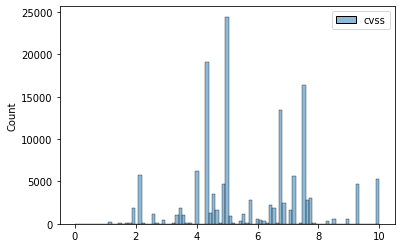

In [38]:
sns.histplot(data=df[['cvss']].dropna())

In [43]:
df[['cvss']].dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143060 entries, 36 to 287883
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cvss    143060 non-null  Float64
dtypes: Float64(1)
memory usage: 2.3 MB


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


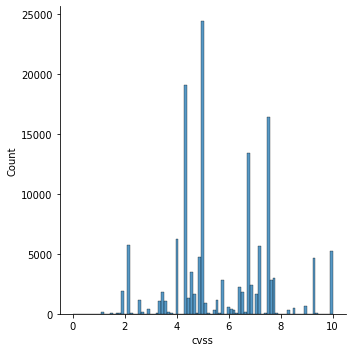

In [48]:
sns.displot(df,x='cvss')

<AxesSubplot: ylabel='Density'>

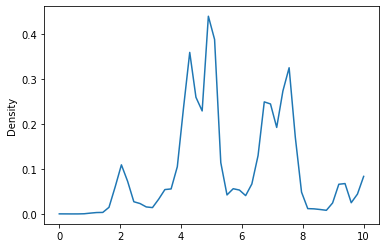

In [53]:
df['cvss'].dropna().plot.kde(ind=np.linspace(0,10))

<AxesSubplot: xlabel='cvss', ylabel='Y'>

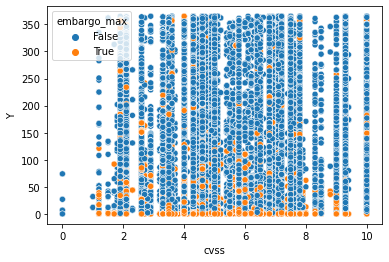

In [54]:
sns.scatterplot(data=df, x='cvss', y='Y', hue='embargo_max')

#### CVSS v2.0 Ratings

In [56]:
cve_columns_categorical

['access.authentication',
 'access.complexity',
 'access.vector',
 'impact.availability',
 'impact.confidentiality',
 'impact.integrity',
 'CVSS v2.0 Ratings',
 'CVSS v3.1 Ratings']

In [59]:
column_name='CVSS v2.0 Ratings'
column_cut=column_name

CVSS v2.0 Ratings
Low       13947
Medium    87935
High      41178
dtype: int64

<AxesSubplot: xlabel='CVSS v2.0 Ratings', ylabel='CVE+project'>

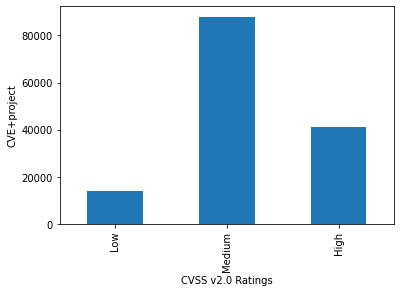

In [61]:
display(df.value_counts(column_cut).sort_index())

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [62]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: 'Low', 1: 'Medium', 2: 'High'}

In [63]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143060, uncensored = 143060
Computing 50 × bootstrap Dxy for 143060 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143060.0,
    "% of cohort": 99.70310692332353,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": -0.030858974019679186,
    "bootstrap": {
        "Dxy": -0.031116439031101,
        "Confidence interval low": -0.03151118258013961,
        "Confidence interval high": -0.030721695482062387,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CVSS v2.0 Ratings,,,,,,,,,
Low,13947,67.0,0,17.0,177.0,365,105.711981,105.131046,0.898061
Medium,87935,47.0,0,9.0,156.0,365,92.988537,103.696482,1.073268
High,41178,45.0,0,7.0,139.0,365,87.655423,100.623109,1.157557


In [64]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

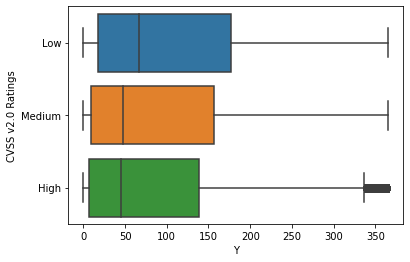

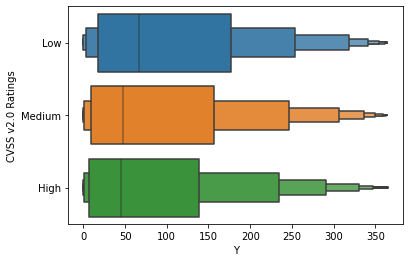

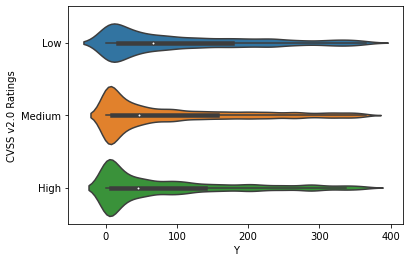

In [65]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


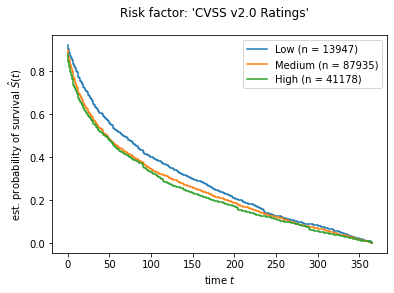

<Figure size 432x288 with 0 Axes>

In [66]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

#### CVSS v3.1 Ratings

In [67]:
column_name='CVSS v3.1 Ratings'
column_cut=column_name

CVSS v3.1 Ratings
None            8
Low         13939
Medium      87935
High        30564
Critical    10614
dtype: int64

<AxesSubplot: xlabel='CVSS v3.1 Ratings', ylabel='CVE+project'>

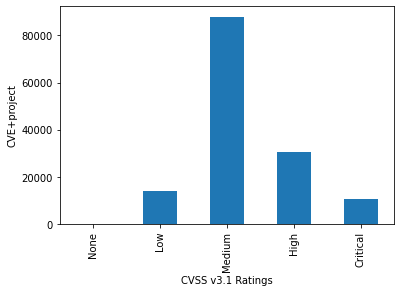

In [68]:
display(df.value_counts(column_cut).sort_index())

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [69]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}

all = 143486, selected = 143060, uncensored = 143060
Computing 50 × bootstrap Dxy for 143060 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143060.0,
    "% of cohort": 99.70310692332353,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": -0.034375908202966765,
    "bootstrap": {
        "Dxy": -0.0343630099531778,
        "Confidence interval low": -0.034811831726786514,
        "Confidence interval high": -0.03391418817956909,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CVSS v3.1 Ratings,,,,,,,,,
None,8,17.0,0,5.25,38.75,74,27.000000,30.882265,0.984818
Low,13939,67.0,0,17.00,177.00,365,105.757156,105.142017,0.897335
Medium,87935,47.0,0,9.00,156.00,365,92.988537,103.696482,1.073268
High,30564,49.0,0,8.00,147.00,365,91.493129,102.231952,1.096995
Critical,10614,35.0,0,3.00,111.00,365,76.604390,94.981920,1.347025


In [70]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

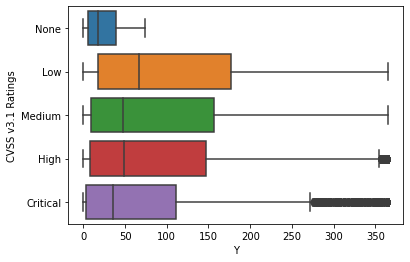

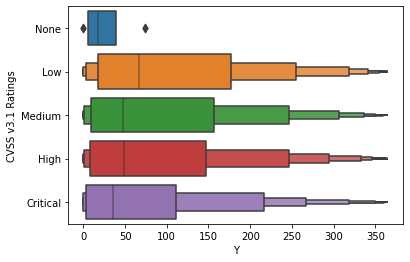

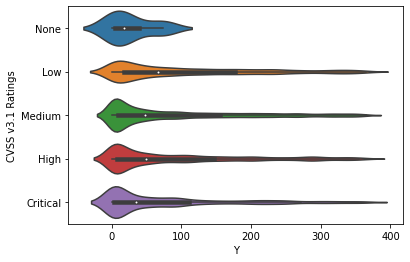

In [71]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


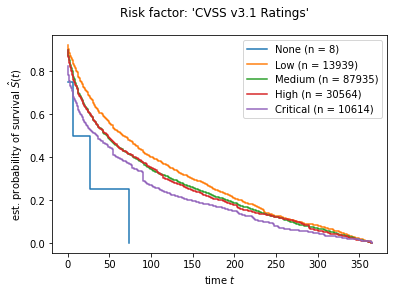

<Figure size 432x288 with 0 Axes>

In [72]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [74]:
print(values_names)
del values_names[0]
del values_hash['None']
print(values_names)`

{0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}
{1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}


In [75]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 143052, uncensored = 143052
Computing 50 × bootstrap Dxy for 143052 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143052.0,
    "% of cohort": 99.69753146648453,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": -0.034422057452046184,
    "bootstrap": {
        "Dxy": -0.03441179016055782,
        "Confidence interval low": -0.034924106949657314,
        "Confidence interval high": -0.03389947337145833,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CVSS v3.1 Ratings,,,,,,,,,
Low,13939,67.0,0,17.0,177.0,365,105.757156,105.142017,0.897335
Medium,87935,47.0,0,9.0,156.0,365,92.988537,103.696482,1.073268
High,30564,49.0,0,8.0,147.0,365,91.493129,102.231952,1.096995
Critical,10614,35.0,0,3.0,111.0,365,76.604390,94.981920,1.347025


In [76]:
results_summary[column_cut+' no None'] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([1, 2, 3, 4])


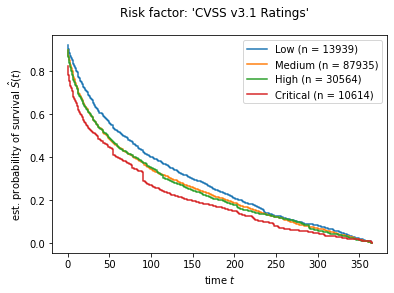

<Figure size 432x288 with 0 Axes>

In [77]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

### access.*

#### access.vector

In [81]:
column_name='access.vector'
column_cut=column_name
df[column_name].head()

36    NETWORK
37    NETWORK
38    NETWORK
39    NETWORK
40    NETWORK
Name: access.vector, dtype: category
Categories (3, object): ['LOCAL' < 'ADJACENT_NETWORK' < 'NETWORK']

access.vector
LOCAL                29538
ADJACENT_NETWORK      2776
NETWORK             110746
dtype: int64

<AxesSubplot: xlabel='access.vector', ylabel='CVE+project'>

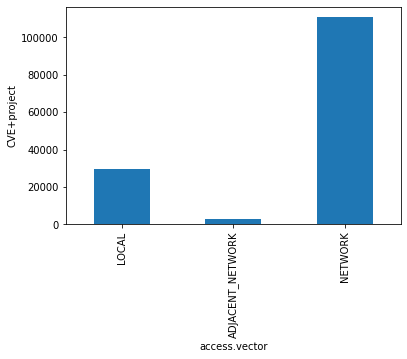

In [82]:
display(df.value_counts(column_cut).sort_index())

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [83]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: 'LOCAL', 1: 'ADJACENT_NETWORK', 2: 'NETWORK'}

all = 143486, selected = 143060, uncensored = 143060
Computing 50 × bootstrap Dxy for 143060 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 143060.0,
    "% of cohort": 99.70310692332353,
    "Survival days, median": 49.0,
    "Survival years, median": 0.13424657534246576,
    "Dxy (full)": -0.05995938915770582,
    "bootstrap": {
        "Dxy": -0.06004123368547778,
        "Confidence interval low": -0.060340601737038126,
        "Confidence interval high": -0.05974186563391743,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
access.vector,,,,,,,,,
LOCAL,29538,79.0,0,20.25,190.00,365,113.761291,107.345346,0.774441
ADJACENT_NETWORK,2776,68.0,0,12.00,180.25,365,106.390850,109.197068,0.832623
NETWORK,110746,42.0,0,7.00,139.00,365,86.731485,100.968766,1.181529


In [84]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

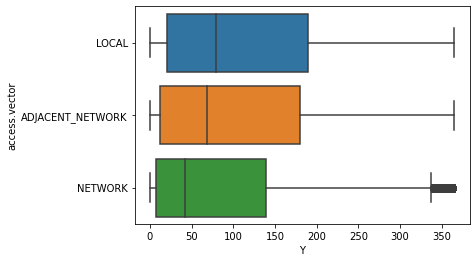

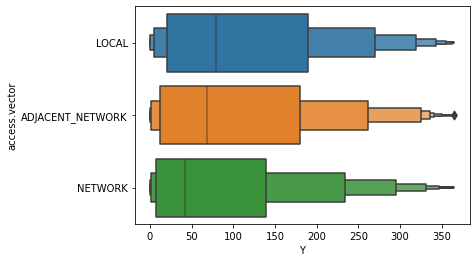

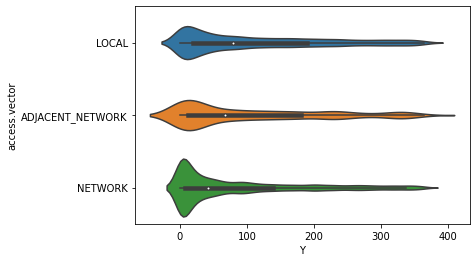

In [85]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


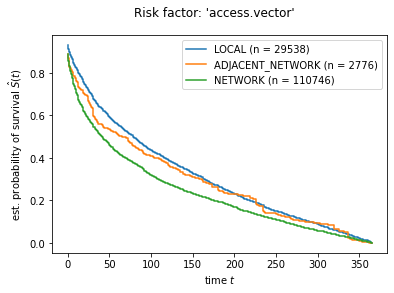

<Figure size 432x288 with 0 Axes>

In [86]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

Delete `ADJACENT_NETWORK` as underrepresented

In [91]:
print(values_names)
del values_names[1]
del values_hash['ADJACENT_NETWORK']
print(values_names)

{0: 'LOCAL', 1: 'ADJACENT_NETWORK', 2: 'NETWORK'}
{0: 'LOCAL', 2: 'NETWORK'}


In [92]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 143486, selected = 140284, uncensored = 140284
Computing 50 × bootstrap Dxy for 140284 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 143486,
    "Number of patients": 140284.0,
    "% of cohort": 97.76842340019235,
    "Survival days, median": 48.0,
    "Survival years, median": 0.13150684931506848,
    "Dxy (full)": -0.05862930832598545,
    "bootstrap": {
        "Dxy": -0.0587992794395123,
        "Confidence interval low": -0.059177619341002206,
        "Confidence interval high": -0.05842093953802239,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
access.vector,,,,,,,,,
LOCAL,29538,79.0,0,20.25,190.0,365,113.761291,107.345346,0.774441
NETWORK,110746,42.0,0,7.00,139.0,365,86.731485,100.968766,1.181529


In [93]:
results_summary[column_cut+' no ADJACENT_NETWORK'] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

#### access.complexity

#### access.vector

### impact.*

#### impact.availability

#### impact.confidentiality

#### impact.integrity

## Summary

In [78]:
summary_df=pd.DataFrame.from_dict(results_summary, orient='index')
summary_df

,cohort,% of cohort,Dxy,Dxy_low,Dxy_high
CVSS v2.0 Ratings,143486,99.703107,-0.031116,-0.031511,-0.031511
CVSS v3.1 Ratings,143486,99.703107,-0.034363,-0.034812,-0.034812
CVSS v3.1 Ratings no None,143486,99.697531,-0.034412,-0.034924,-0.034924


<AxesSubplot: title={'center': 'Dxy'}>

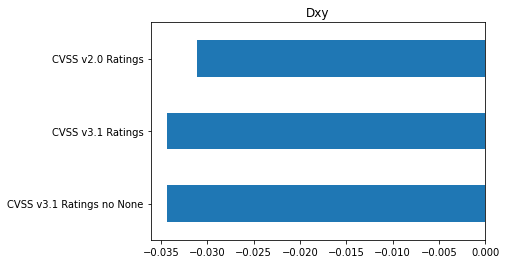

In [79]:
summary_df['Dxy'].sort_values().plot(kind='barh',title='Dxy')

In [80]:
ver='365days'
summary_df.to_csv(f"survey_analysis_CVE_metadata.{ver}.csv")